### 予約をキャンセルするかしないかの分類問題です。

In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)

予測するのは'is_canceled'で、1がキャンセル、0が予約です。

In [2]:
pd.set_option("display.max_columns",100)
df=pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
#データの型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
#欠損値の確認
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
trace=go.Bar(
                        x=df['country'].value_counts().index,
                        y=df['country'].value_counts(),
                        name='Country')
layout=go.Layout(title='country',
                                legend=dict(orientation='h'))

data=[trace]
fig=go.Figure(data,layout)
iplot(fig)

In [6]:
#countryはPRTが圧倒的に多かった為、最頻値で補完
df['country']=df['country'].fillna(df['country'].mode()[0])

In [7]:
#childrenは欠損値が少ない為0で補完
df['children']=df['children'].fillna(0)

In [8]:
#agentの欠損値の割合を計算
print(df['agent'].value_counts().sum())
print(df['agent'].isnull().sum()/df['agent'].value_counts().sum())

103050
0.15856380397865114


In [9]:
#'agent','company'は欠損値が多く使えない為、削除
df.drop(columns=['agent','company'],axis=1,inplace=True)
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

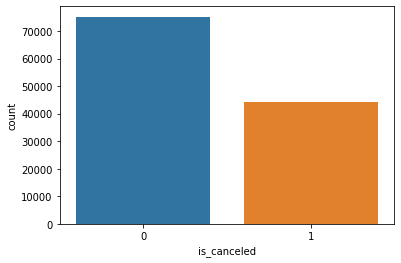

In [10]:
#キャンセルと予約の可視化
sns.countplot(df['is_canceled'])

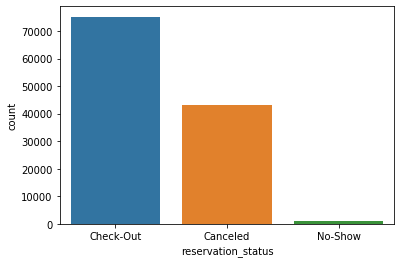

In [11]:
#チェックアウト済かキャンセルか連絡なくキャンセルかを可視化
sns.countplot(df['reservation_status'])

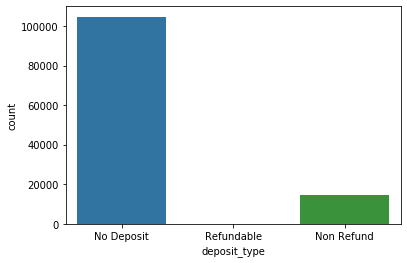

In [12]:
#事前に宿泊代を払うかどうか。Non Refundは返金できない。No Depositは前払い不要。Rrefundable deposit_typeは返金可能で前払い
sns.countplot(df['deposit_type'])

In [13]:
df.select_dtypes(exclude='object')

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,27,1,0,0,2,0.0,0,0,0,0,3,0,0.00,0,0
1,0,737,2015,27,1,0,0,2,0.0,0,0,0,0,4,0,0.00,0,0
2,0,7,2015,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
3,0,13,2015,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,0,0,0,0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0
119386,0,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2
119387,0,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4
119388,0,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0


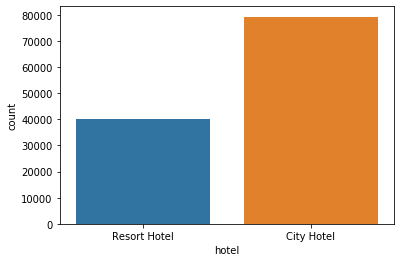

In [14]:
#ホテルタイプの可視化
sns.countplot(df['hotel'])

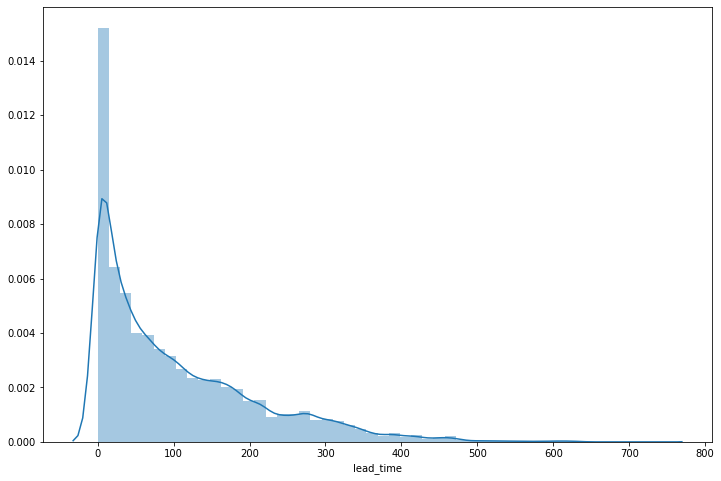

In [15]:
#lead_time(チェックインの何日前から予約したかのグラフ)
plt.figure(figsize=(12,8))
sns.distplot(df['lead_time'])

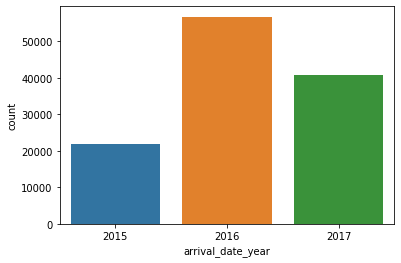

In [16]:
#年ごとでの予約（キャンセルも含む）
sns.countplot(df['arrival_date_year'])

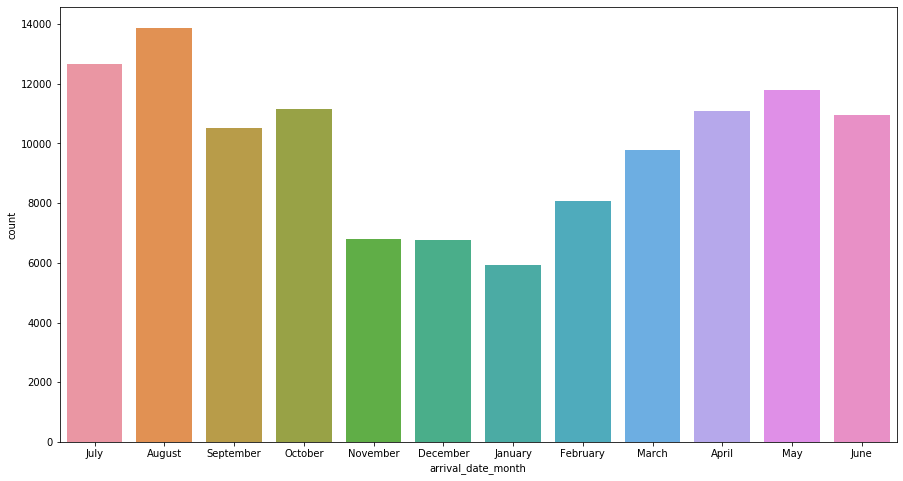

In [17]:
#月ごとでの予約（キャンセルも含む）
plt.figure(figsize=(15,8))
sns.countplot(df['arrival_date_month'])

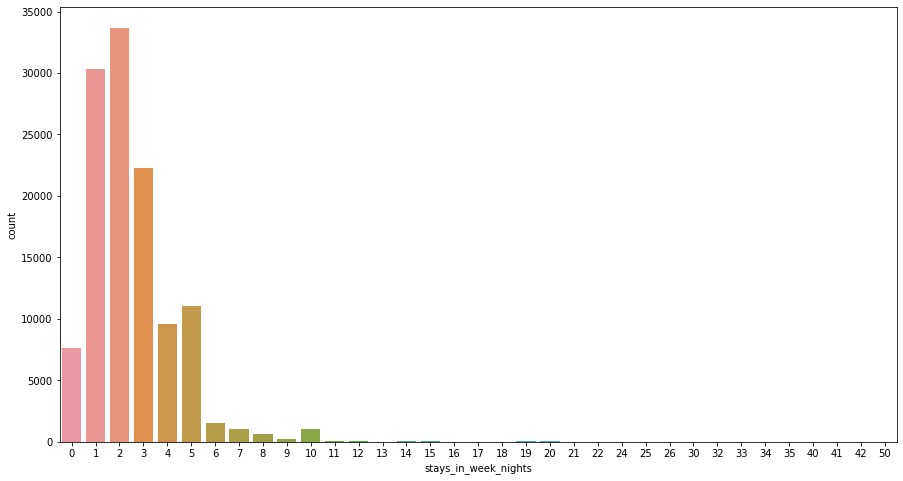

In [18]:
#stays_in_week_nights(泊まる日が平日だった日数)
plt.figure(figsize=(15,8))
sns.countplot(df['stays_in_week_nights'])

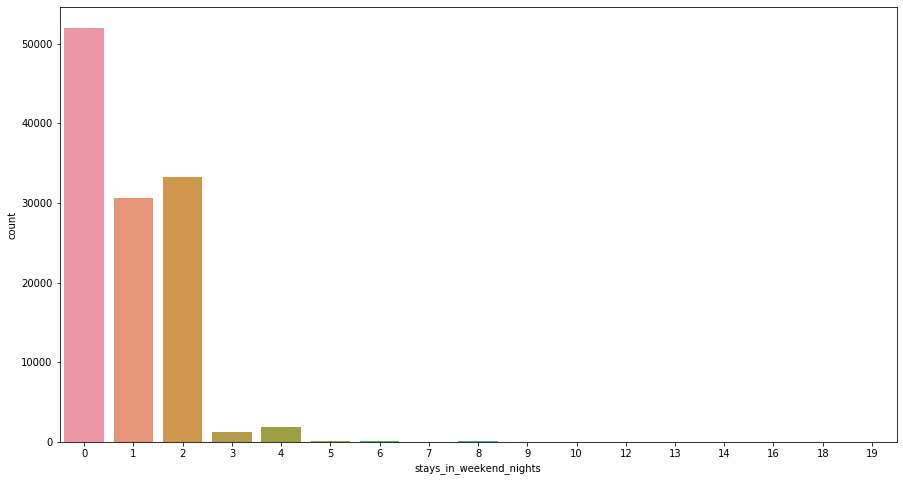

In [19]:
#stays_in_weekend_nights(泊まる日が週末だった日数)
plt.figure(figsize=(15,8))
sns.countplot(df['stays_in_weekend_nights'])

In [20]:
#キャンセルと予約だったもののadr(料金)の平均　　　　０が予約、1がキャンセル
df[['is_canceled','adr']].groupby('is_canceled').mean()

,adr
is_canceled,
0,99.987693
1,104.964333


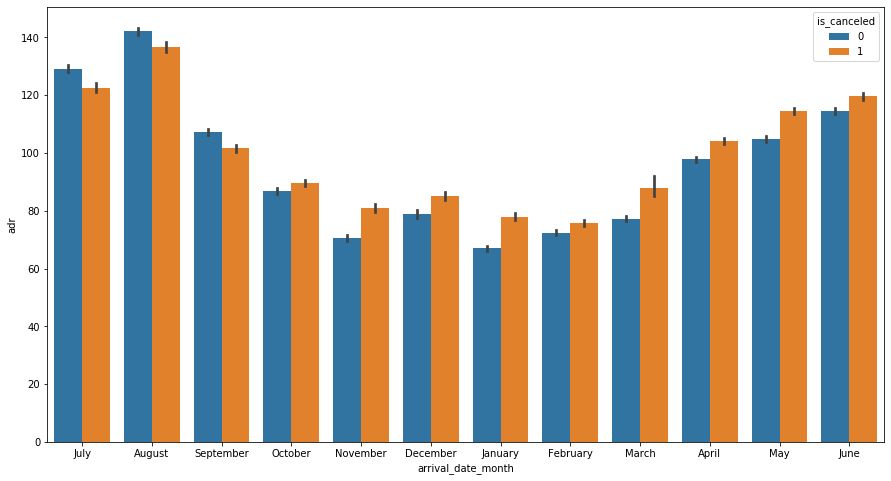

In [21]:
#利用月の可視化
plt.figure(figsize=(15,8))
sns.barplot(x=df['arrival_date_month'],y=df['adr'],hue='is_canceled',data=df)

In [22]:
#宿泊客がどこの国だったかの可視化
trace=go.Bar(
                        x=df['country'].value_counts().index,
                        y=df['country'].value_counts(),
                        name='Country')
layout=go.Layout(title='country',
                                legend=dict(orientation='h'))

data=[trace]
fig=go.Figure(data,layout)
iplot(fig)

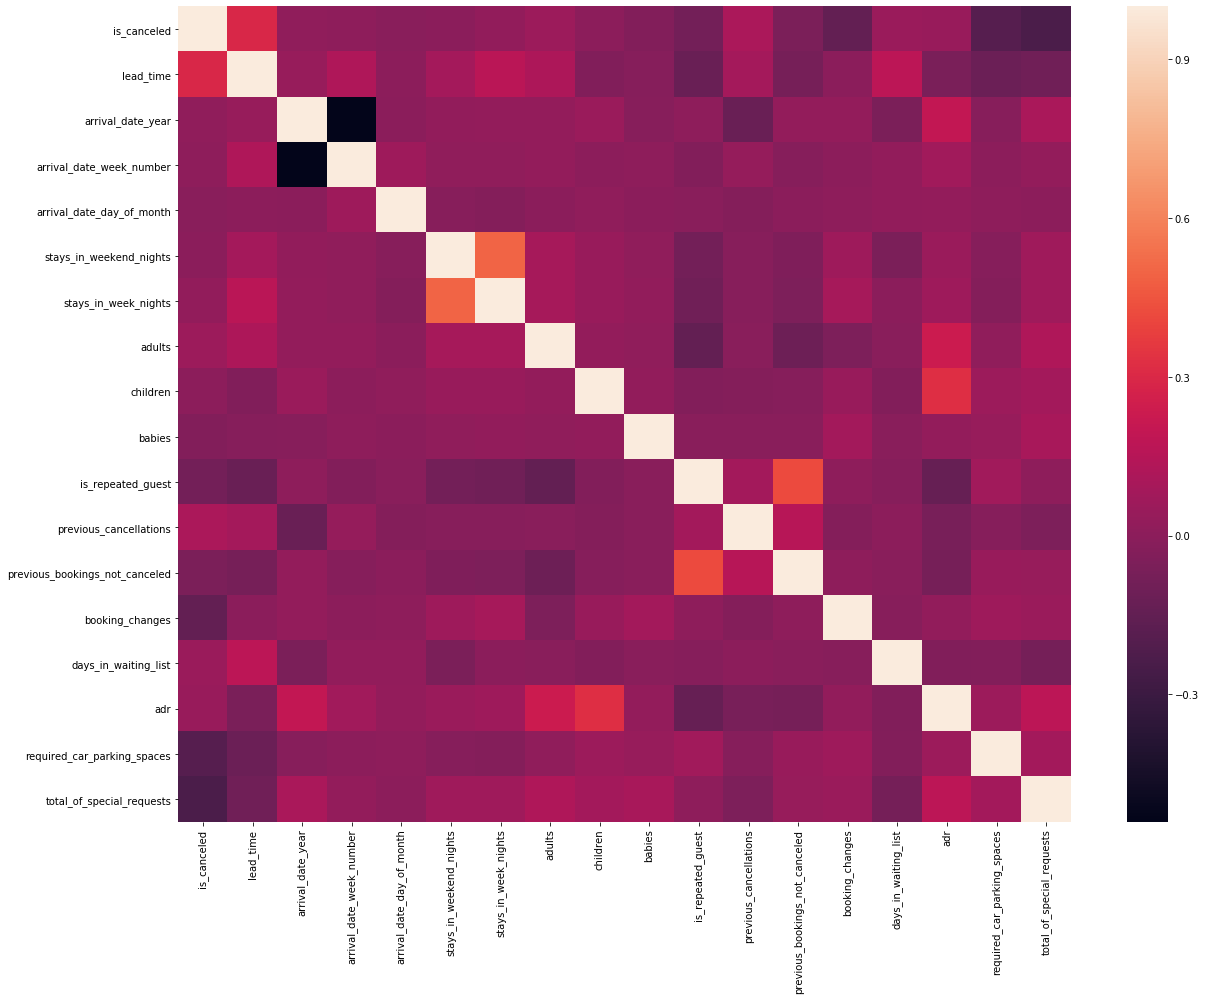

In [23]:
#相関を確認
plt.figure(figsize=(20,15))
sns.heatmap(df.corr())

In [24]:
#数値型でカテゴリ変数のものを確認
print(df['total_of_special_requests'].unique())
print(df['required_car_parking_spaces'].unique())
print(df['previous_bookings_not_canceled'].unique())

[0 1 3 2 4 5]
[0 1 2 8 3]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 27 28 29 30 19 26 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]


In [25]:
#データ型がobjectでいいかどうかを確認
df.select_dtypes(exclude='object')

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,2015,27,1,0,0,2,0.0,0,0,0,0,3,0,0.00,0,0
1,0,737,2015,27,1,0,0,2,0.0,0,0,0,0,4,0,0.00,0,0
2,0,7,2015,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
3,0,13,2015,27,1,0,1,1,0.0,0,0,0,0,0,0,75.00,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,0,0,0,0,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0
119386,0,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2
119387,0,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4
119388,0,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0


In [26]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [27]:
df['arrival_date_month']=df['arrival_date_month'].map({'July':'07','August':'08','September':'09','October':'10','November':'11','December':'12',
                                                      'January':'01','February':'02','March':'03','April':'04','May':'05','June':'06'})

In [28]:
#arrival_date_week_number(到着日の年の週番号)　相関があるか確認
df[['is_canceled','arrival_date_week_number']].groupby('is_canceled',as_index=False).mean()

,is_canceled,arrival_date_week_number
0,0,27.080143
1,1,27.309696


In [29]:
#adults(大人の人数)に外れ値がないか確認。
df['adults'].unique()

array([ 2,  1,  3,  4, 40, 26, 50, 27, 55,  0, 20,  6,  5, 10])

In [30]:
#大人0人などがあったので最頻値で補完
df['adults']=df['adults'].fillna(df['adults'].mode()[0])

In [31]:
#children(子供の人数)に外れ値がないか確認。
df['children'].unique()

array([ 0.,  1.,  2., 10.,  3.])

In [32]:
#新たにfamily（大人+子供+赤ちゃん）の特徴量を追加
df['family']=df['adults']+df['children']+df['babies']

In [33]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,family
0,Resort Hotel,0,342,2015,07,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2.0
1,Resort Hotel,0,737,2015,07,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2.0
2,Resort Hotel,0,7,2015,07,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,1.0
3,Resort Hotel,0,13,2015,07,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,1.0
4,Resort Hotel,0,14,2015,07,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2.0


#### カテゴリ変数をラベルエンコーディング

In [34]:
from sklearn.preprocessing import LabelEncoder

label_col=['hotel','meal','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type',
                  'deposit_type','customer_type']

for col in label_col:
    lbl=LabelEncoder()
    df[col]=lbl.fit_transform(df[col].values)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,family
0,1,0,342,2015,07,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,3,0,0,2,0.0,0,0,Check-Out,2015-07-01,2.0
1,1,0,737,2015,07,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,4,0,0,2,0.0,0,0,Check-Out,2015-07-01,2.0
2,1,0,7,2015,07,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0,0,2,75.0,0,0,Check-Out,2015-07-02,1.0
3,1,0,13,2015,07,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,0,0,2,75.0,0,0,Check-Out,2015-07-02,1.0
4,1,0,14,2015,07,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,0,0,2,98.0,0,1,Check-Out,2015-07-03,2.0


In [35]:
#is_canceledと相関があるものなどを削除
df=df.drop(columns=['reservation_status','reservation_status_date','reserved_room_type',
                   'arrival_date_week_number','previous_cancellations','previous_bookings_not_canceled',
                   'days_in_waiting_list','stays_in_week_nights','booking_changes','distribution_channel'],axis=1)

- reservation_status(予約の状態がキャンセルか予約が分かり、説明変数に入れると正しく分類されない可能性がある)

その他、adr(料金)やbooking_changes(予約を変更した回数)などに関しても予約したかどうかがわかってしまう可能性がある特徴量を削除

In [36]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,assigned_room_type,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,family
0,1,0,342,2015,07,1,0,2,0.0,0,0,135,3,0,2,0,2,0.0,0,0,2.0
1,1,0,737,2015,07,1,0,2,0.0,0,0,135,3,0,2,0,2,0.0,0,0,2.0
2,1,0,7,2015,07,1,0,1,0.0,0,0,59,3,0,2,0,2,75.0,0,0,1.0
3,1,0,13,2015,07,1,0,1,0.0,0,0,59,2,0,0,0,2,75.0,0,0,1.0
4,1,0,14,2015,07,1,0,2,0.0,0,0,59,6,0,0,0,2,98.0,0,1,2.0


#### ダミー変数化

In [37]:
df=pd.get_dummies(df,drop_first=True)

In [38]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,assigned_room_type,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,family,arrival_date_month_02,arrival_date_month_03,arrival_date_month_04,arrival_date_month_05,arrival_date_month_06,arrival_date_month_07,arrival_date_month_08,arrival_date_month_09,arrival_date_month_10,arrival_date_month_11,arrival_date_month_12
0,1,0,342,2015,1,0,2,0.0,0,0,135,3,0,2,0,2,0.0,0,0,2.0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,737,2015,1,0,2,0.0,0,0,135,3,0,2,0,2,0.0,0,0,2.0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,7,2015,1,0,1,0.0,0,0,59,3,0,2,0,2,75.0,0,0,1.0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,13,2015,1,0,1,0.0,0,0,59,2,0,0,0,2,75.0,0,0,1.0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,14,2015,1,0,2,0.0,0,0,59,6,0,0,0,2,98.0,0,1,2.0,0,0,0,0,0,1,0,0,0,0,0


In [39]:
#数値型の特徴量をスケーリング
from sklearn.preprocessing import StandardScaler

num_col=['stays_in_weekend_nights','adults','children','babies','family','adr','lead_time']
for col in num_col:
    scaler=StandardScaler()
    df[col]=scaler.fit_transform(np.array(df[col].values).reshape(-1,1))
    
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,assigned_room_type,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,family,arrival_date_month_02,arrival_date_month_03,arrival_date_month_04,arrival_date_month_05,arrival_date_month_06,arrival_date_month_07,arrival_date_month_08,arrival_date_month_09,arrival_date_month_10,arrival_date_month_11,arrival_date_month_12
0,1,0,2.227051,2015,1,-0.92889,0.247897,-0.260659,-0.081579,0,135,3,0,2,0,2,-2.015038,0,0,0.043967,0,0,0,0,0,1,0,0,0,0,0
1,1,0,5.923385,2015,1,-0.92889,0.247897,-0.260659,-0.081579,0,135,3,0,2,0,2,-2.015038,0,0,0.043967,0,0,0,0,0,1,0,0,0,0,0
2,1,0,-0.907814,2015,1,-0.92889,-1.478447,-0.260659,-0.081579,0,59,3,0,2,0,2,-0.530935,0,0,-1.340324,0,0,0,0,0,1,0,0,0,0,0
3,1,0,-0.851667,2015,1,-0.92889,-1.478447,-0.260659,-0.081579,0,59,2,0,0,0,2,-0.530935,0,0,-1.340324,0,0,0,0,0,1,0,0,0,0,0
4,1,0,-0.842309,2015,1,-0.92889,0.247897,-0.260659,-0.081579,0,59,6,0,0,0,2,-0.075810,0,1,0.043967,0,0,0,0,0,1,0,0,0,0,0


In [40]:
df.shape

(119390, 31)

In [41]:
#説明変数をXに、目的変数をyに代入
X=df.drop(columns=['is_canceled'],axis=1)
y=df['is_canceled']
print(X.shape)
print(y.shape)

(119390, 30)
(119390,)


### 交差検証でモデル選択

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score,KFold

In [43]:
KFold=KFold(n_splits=5,shuffle=True,random_state=0)
Random_cross=RandomForestClassifier()
svc_cross=LinearSVC()

In [44]:
random_score=cross_val_score(Random_cross,X,y,cv=KFold)
svc_score=cross_val_score(svc_cross,X,y,cv=KFold)

In [45]:
print('RandomForest:{}'.format(random_score.mean()))
print('SVC:{}'.format(svc_score.mean()))

RandomForest:0.8830220286456152
SVC:0.6165089203450875


In [46]:
#訓練データとテストデータに分割
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [47]:
from sklearn.metrics import f1_score

In [48]:
#モデルの作成
random_forest=RandomForestClassifier()
random_forest.fit(X_train,y_train)
pred_y=random_forest.predict(X_test)
print(random_forest.score(X_test,y_test))

0.8773117126775664


### グリッドサーチ

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
params_random={'max_depth':[i for i in range(6,16)]}

clf_grid=GridSearchCV(RandomForestClassifier(),params_random,scoring='accuracy')
clf_grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
             scoring='accuracy')

In [51]:
clf_grid.score(X_train,y_train)

0.8835406848182975

In [52]:
clf_grid.score(X_test,y_test)

0.8588180112570356

In [53]:
clf_grid.best_score_

0.8584686469866091